(Transaction_data_Simulator)=
# Transaction data simulator


This section presents a transaction data simulator of legitimate and fraudulent transactions. This simulator will be used throughout the rest of this book to motivate and assess the efficiency of different fraud detection techniques in a reproducible way. 

A simulation is necessarily an approximation of reality. Compared to the complexity of the dynamics underlying real-world payment card transaction data, the data simulator that we present below follows a simple design. 

This simple design is a choice. First, having simple rules to generate transactions and fraudulent behaviors will help in interpreting the kind of patterns that different fraud detection techniques can identify. Second, while simple in its design, the data simulator will generate datasets that are challenging to deal with. 

The simulated datasets will highlight most of the issues that practitioners of fraud detection face using real-world data. In particular, they will include class imbalance (less than 1% of fraudulent transactions), a mix of numerical and categorical features (with categorical features involving a very large number of values), non-trivial relationships between features, and time-dependent fraud scenarios.

<h3>Design choices</h3>

<h4>Transaction features</h4>

Our focus will be on the most essential features of a transaction. In essence, a payment card transaction consists of any amount paid to a merchant by a customer at a certain time. The six main features that summarise a transaction therefore are:

1. The transaction ID: A unique identifier for the transaction
2. The date and time: Date and time at which the transaction occurs
3. The customer ID: The identifier for the customer. Each customer has a unique identifier
4. The terminal ID: The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier
5. The transaction amount: The amount of the transaction.
6. The fraud label: A binary variable, with the value $0$ for a legitimate transaction, or the value $1$ for a fraudulent transaction.

These features will be referred to as `TRANSACTION_ID`, `TX_DATETIME`, `CUSTOMER_ID`, `TERMINAL_ID`, `TX_AMOUNT`, and `TX_FRAUD`. 

The goal of the transaction data simulator will be to generate a table of transactions with these features. This table will be referred to as the *labeled transactions* table. Such a table is illustrated in Fig. 1. 

![alt text](images/tx_table.png)
<p style="text-align: center;">
Fig. 1. Example of labeled transaction table. Each transaction is represented as a row in the table,<br> together with its label (TX_FRAUD variable, 0 for legitimate, and 1 for fraudulent transactions).
</p>
    


## Customer profiles generation

Each customer will be defined by the following properties:

* `CUSTOMER_ID`: The customer unique ID
* (`x_customer_id`,`y_customer_id`): A pair of real coordinates (`x_customer_id`,`y_customer_id`) in a 100 * 100 grid, that defines the geographical location of the customer
* (`mean_amount`, `std_amount`):  The mean and standard deviation of the transaction amounts for the customer, assuming that the transaction amounts follow a normal distribution. The `mean_amount` will be drawn from a uniform distribution (5,100) and the `std_amount` will be set as the `mean_amount` divided by two. 
* `mean_nb_tx_per_day`:  The average number of transactions per day for the customer, assuming that the number of transactions per day follows a Poisson distribution. This number will be drawn from a uniform distribution (0,4). 

The `generate_customer_profiles_table` function provides an implementation for generating a table of customer profiles. It takes as input the number of customers for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each customer. 

<h4>Transaction generation process</h4>

The simulation will consist of five main steps:

1. Generation of customer profiles: Every customer is different in their spending habits. This will be simulated by defining some properties for each customer. The main properties will be their geographical location, their spending frequency, and their spending amounts. The customer properties will be represented as a table, referred to as the *customer profile table*. 
2. Generation of terminal profiles: Terminal properties will simply consist of a geographical location. The terminal properties will be represented as a table, referred to as the *terminal profile table*.
3. Association of customer profiles to terminals: We will assume that customers only make transactions on terminals that are within a radius of $r$ of their geographical locations. This makes the simple assumption that a customer only makes transactions on terminals that are geographically close to their location. This step will consist of adding a feature 'list_terminals' to each customer profile, that contains the set of terminals that a customer can use.
4. Generation of transactions: The simulator will loop over the set of customer profiles, and generate transactions according to their properties (spending frequencies and amounts, and available terminals). This will result in a table of transactions.
5. Generation of fraud scenarios: This last step will label the transactions as legitimate or genuine. This will be done by following three different fraud scenarios.

The transaction generation process is illustrated below. 

![alt text](images/FlowDatasetGenerator.png)
<p style="text-align: center;">
Fig. 2. Transaction generation process. The customer and terminal profiles are used to generate  <br> a set of transactions. The final step, which generates fraud scenarios, provides the labeled transactions table.
   

The following sections detail the implementation for each of these steps. 
    

In [1]:
import qualified DataFrame as D
import           Data.List
import           DataFrame.Internal.Row (Any)
import           DataFrame (DataFrame, (|>))
import           System.Random

generateCustomerProfiles :: Int -> Int -> DataFrame 
generateCustomerProfiles nCustomers seed = D.fromRows columns customerRows
    where
        columns = ["CUSTOMER_ID", "x_customer_id", "y_customer_id", "mean_amount", "std_amount", "mean_nb_tx_per_day"]
        customerRows = reverse (snd (foldl' mkCustomerRow (mkStdGen seed, []) [0..(nCustomers - 1)]))
    
mkCustomerRow :: (RandomGen g) => (g, [[Any]]) -> Int -> (g, [[Any]])
mkCustomerRow (initState, customers) i = (stateNumTransactions, customer:customers) 
    where
        (customerXCoordinate, stateX) = uniformR (0 :: Double, 100 :: Double) initState
        (customerYCoordinate, stateY) = uniformR (0 :: Double, 100 :: Double) stateX
        (meanAmount, stateAmount) = uniformR (5 :: Double, 100 :: Double) stateY
        (meanNumberOfTransactionsPerDay, stateNumTransactions) = uniformR (0 :: Double, 4 :: Double) stateAmount
        customer = [ D.toAny i
                   , D.toAny customerXCoordinate
                   , D.toAny customerYCoordinate
                   , D.toAny meanAmount
                   , D.toAny (meanAmount / 2) -- arbitrary but sensible std dev amount
                   , D.toAny meanNumberOfTransactionsPerDay]

As an example, let us generate a customer profile table for five customers:

In [2]:
nCustomers = 5
customerProfilesTable = generateCustomerProfiles nCustomers {- randomSeed -} 42
customerProfilesTable

  ----------------------------------------------------------------------------------------------------------------------------------------------------  
| CUSTOMER_ID<br>Int | x_customer_id<br>Double | y_customer_id<br>Double | mean_amount<br>Double | std_amount<br>Double | mean_nb_tx_per_day<br>Double |
| -------------------|-------------------------|-------------------------|-----------------------|----------------------|----------------------------- |
| 0                  | 93.0852402521634        | 6.472345419562502       | 89.11958040947711     | 44.559790204738555   | 3.4087963035591997           |
| 1                  | 75.01453784152332       | 10.033733661000873      | 7.625126650354998     | 3.812563325177499    | 2.6012427627451142           |
| 2                  | 56.17534340582974       | 38.108041498656284      | 6.686602930178612     | 3.343301465089306    | 0.6573720290648454           |
| 3                  | 88.92180258692886       | 33.57553953745931       | 24.936683410996707    | 12.468341705498354   | 0.9841990594424566           |
| 4                  | 44.045662546726106      | 3.80799872779816        | 69.79580663353767     | 34.89790331676883    | 0.6270417603643902           |


## Terminal profiles generation

Each terminal will be defined by the following properties:

* `TERMINAL_ID`: The terminal ID
* (`x_terminal_id`,`y_terminal_id`): A pair of real coordinates (`x_terminal_id`,`y_terminal_id`) in a 100 * 100 grid, that defines the geographical location of the terminal

The `generate_terminal_profiles_table` function provides an implementation for generating a table of terminal profiles. It takes as input the number of terminals for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each terminal. 


In [3]:
generateTerminalProfiles :: Int -> Int -> DataFrame 
generateTerminalProfiles nTerminals seed = D.fromRows columns terminalRows
    where
        columns = ["TERMINAL_ID", "x_terminal_id", "y_terminal_id"]
        terminalRows = reverse (snd (foldl' mkTerminalRow (mkStdGen seed, []) [0..(nTerminals - 1)]))
    
mkTerminalRow :: (RandomGen g) => (g, [[Any]]) -> Int -> (g, [[Any]])
mkTerminalRow (initState, terminals) i = (stateY, terminal:terminals) 
    where
        (terminalXCoordinate, stateX) = uniformR (0 :: Double, 100 :: Double) initState
        (terminalYCoordinate, stateY) = uniformR (0 :: Double, 100 :: Double) stateX
        terminal = [ D.toAny i
                   , D.toAny terminalXCoordinate
                   , D.toAny terminalYCoordinate]

As an example, let us generate a customer terminal table for five terminals:

In [4]:
nTerminals = 5
terminalProfilesTable = generateTerminalProfiles nTerminals {- randomSeed -} 56
terminalProfilesTable

  ----------------------------------------------------------------------  
| TERMINAL_ID<br>Int | x_terminal_id<br>Double | y_terminal_id<br>Double |
| -------------------|-------------------------|------------------------ |
| 0                  | 76.39783658643042       | 83.48643691825139       |
| 1                  | 16.476527749000212      | 23.501361193042474      |
| 2                  | 29.75855364730092       | 7.877603519521759       |
| 3                  | 81.10186528375517       | 38.379216773732864      |
| 4                  | 92.91006005139633       | 89.12260752096157       |


## Association of customer profiles to terminals

Let us now associate terminals with the customer profiles. In our design, customers can only perform transactions on terminals that are within a radius of `r` of their geographical locations. 

Let us first write a function, called `get_list_terminals_within_radius`, which finds these terminals for a customer profile. The function will take as input a customer profile (any row in the customer profiles table), an array that contains the geographical location of all terminals, and the radius `r`. It will return the list of terminals within a radius of `r` for that customer. 

In [5]:
-- Make the columns available as expressions.

F.declareColumns terminalProfilesTable
F.declareColumns customerProfilesTable

In [6]:
import DataFrame.Functions ((.<), (.==))
import DataFrame.Monad

getListTerminalsWithinRadius :: Int -> DataFrame -> DataFrame -> Int -> [Int]
getListTerminalsWithinRadius cId customers terminals radius =
    let
        mkTuple = F.lift2 (,)
        dist (terminalX, terminalY) = sqrt ((customerX - terminalX) ^ 2 + (customerY - terminalY) ^ 2)
        (customerX, customerY) = evalFrameM customers $ do
            filterWhereM (customer_id .== F.lit cId)
            xy <- deriveM "x_y" (mkTuple x_customer_id y_customer_id)
            inspectM (head . D.columnAsList xy)
        availableTerminals = evalFrameM terminals $ do
            xy <- deriveM "x_y" (mkTuple x_terminal_id y_terminal_id)
            filterWhereM (F.lift dist xy .< F.toDouble (F.lit radius))
            inspectM (D.columnAsList terminal_id)
    in availableTerminals
    

As an example, let us get the list of terminals that are within a radius $r=50$ of the last customer:

In [7]:
getListTerminalsWithinRadius {- customerId -} 4 customerProfilesTable terminalProfilesTable {- radius -} 50

[1,2]

The list contains the second and third terminals, which are indeed the only ones within a radius of $50$ of the last customer. 

In [8]:
terminalProfilesTable

  ----------------------------------------------------------------------  
| TERMINAL_ID<br>Int | x_terminal_id<br>Double | y_terminal_id<br>Double |
| -------------------|-------------------------|------------------------ |
| 0                  | 76.39783658643042       | 83.48643691825139       |
| 1                  | 16.476527749000212      | 23.501361193042474      |
| 2                  | 29.75855364730092       | 7.877603519521759       |
| 3                  | 81.10186528375517       | 38.379216773732864      |
| 4                  | 92.91006005139633       | 89.12260752096157       |


For better visualization, let us plot
* The locations of all terminals (in red)
* The location of the last customer (in blue)
* The region within radius of 50 of the first customer (in green)


In [9]:
import Graphics.Vega.VegaLite hiding (filter, lookup)
import IHaskell.Display.Hvega

terminals :: [(Double, Double)]
terminals = D.columnAsList (F.lift2 (,) x_terminal_id y_terminal_id) terminalProfilesTable

customerX, customerY :: Double
(customerX, customerY) = customerProfilesTable |> D.filterWhere (customer_id .== 4)
                                               |> D.columnAsList (F.lift2 (,) x_customer_id y_customer_id)
                                               |> head

radius :: Double
radius = 50

plotWidth, plotHeight :: Int
(plotWidth, plotHeight) = (400, 400)

-- The radiius of the circle in pixels^2.
-- Area = pi * (radius * (pixels / range))^2
-- Plot is 400px for domain [0,100], so 1 data unit = 4px
circleSize :: Double
circleSize = pi * (radius * 4) ^ (2 :: Int)

visualization :: VegaLite
visualization = 
    let 
        xDomain = SDomain (DNumbers [0, 100])
        yDomain = SDomain (DNumbers [0, 100])
        tickVals = Numbers [0, 20, 40, 60, 80, 100]
        
        circleData = dataFromColumns []
            . dataColumn "x" (Numbers [customerX])
            . dataColumn "y" (Numbers [customerY])
            $ []
        
        circleEnc = encoding
            . position X [ PName "x"
                         , PmType Quantitative
                         , PScale [xDomain]
                         ]
            . position Y [ PName "y"
                         , PmType Quantitative
                         , PScale [yDomain]
                         ]
            $ []
        
        circleSpec = asSpec 
            [ circleData
            , mark Circle [MSize circleSize, MColor "lightgreen", MOpacity 0.7, MClip True]
            , circleEnc
            ]
        
        terminalData = dataFromColumns []
            . dataColumn "x" (Numbers $ map fst terminals)
            . dataColumn "y" (Numbers $ map snd terminals)
            $ []
        
        terminalEnc = encoding
            . position X [ PName "x"
                         , PmType Quantitative
                         , PScale [xDomain]
                         , PAxis [ AxTitle "x_terminal_id"
                                 , AxGrid True
                                 , AxGridColor "#ddd"
                                 , AxValues tickVals
                                 ]
                         ]
            . position Y [ PName "y"
                         , PmType Quantitative
                         , PScale [yDomain]
                         , PAxis [ AxTitle "y_terminal_id"
                                 , AxGrid True
                                 , AxGridColor "#ddd"
                                 , AxValues tickVals
                                 ]
                         ]
            $ []
        
        terminalSpec = asSpec
            [ terminalData
            , mark Circle [MSize 100, MColor "blue"]
            , terminalEnc
            ]
        
        customerData = dataFromColumns []
            . dataColumn "x" (Numbers [customerX])
            . dataColumn "y" (Numbers [customerY])
            $ []
        
        customerEnc = encoding
            . position X [ PName "x"
                         , PmType Quantitative
                         , PScale [xDomain]
                         ]
            . position Y [ PName "y"
                         , PmType Quantitative
                         , PScale [yDomain]
                         ]
            $ []
        
        customerSpec = asSpec
            [ customerData
            , mark Circle [MSize 100, MColor "red"]
            , customerEnc
            ]
        
    in toVegaLite
        [ title "Green circle:\nTerminals within a radius of 50\nof the last customer" []
        , width 400
        , height 400
        , resolve . resolution (RAxis [(ChX, Independent), (ChY, Independent)]) $ []
        , configure
            . configuration (ViewStyle [ViewFill "#f8f8f8"])
            $ []
        , layer [circleSpec, terminalSpec, customerSpec]
        ]

vlShow visualization


Computing the list of available terminals for each customer is then straightforward, using the panda `apply` function. We store the results as a new column `available_terminals` in the customer profiles table.

In [10]:
import DataFrame.Monad

getListTerminalsWithinRadius :: (Double, Double) -> DataFrame -> Int -> [Int]
getListTerminalsWithinRadius (customerX, customerY) terminals radius =
    let
        mkTuple = F.lift2 (,)
        dist (terminalX, terminalY) = sqrt ((customerX - terminalX) ^ 2 + (customerY - terminalY) ^ 2)
        availableTerminals = evalFrameM terminals $ do
                xy <- deriveM "x_y" (mkTuple x_terminal_id y_terminal_id)
                filterWhereM (F.lift dist xy .< F.toDouble (F.lit radius))
                inspectM (D.columnAsList terminal_id)
    in availableTerminals

customerWithAvailableTerminals = customerProfilesTable |> D.derive "available_terminals" (F.lift2 (\x y -> getListTerminalsWithinRadius (x, y) terminalProfilesTable 50) x_customer_id y_customer_id)

customerWithAvailableTerminals

  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  
| CUSTOMER_ID<br>Int | x_customer_id<br>Double | y_customer_id<br>Double | mean_amount<br>Double | std_amount<br>Double | mean_nb_tx_per_day<br>Double | available_terminals<br>[Int] |
| -------------------|-------------------------|-------------------------|-----------------------|----------------------|------------------------------|----------------------------- |
| 0                  | 93.0852402521634        | 6.472345419562502       | 89.11958040947711     | 44.559790204738555   | 3.4087963035591997           | [3]                          |
| 1                  | 75.01453784152332       | 10.033733661000873      | 7.625126650354998     | 3.812563325177499    | 2.6012427627451142           | [2,3]                        |
| 2                  | 56.17534340582974       | 38.108041498656284      | 6.686602930178612     | 3.343301465089306    | 0.6573720290648454           | [0,1,2,3]                    |
| 3                  | 88.92180258692886       | 33.57553953745931       | 24.936683410996707    | 12.468341705498354   | 0.9841990594424566           | [3]                          |
| 4                  | 44.045662546726106      | 3.80799872779816        | 69.79580663353767     | 34.89790331676883    | 0.6270417603643902           | [1,2]                        |


It is worth noting that the radius $r$ controls the number of terminals that will be on average available for each customer. As the number of terminals is increased, this radius should be adapted to match the average number of available terminals per customer that is desired in a simulation.  

## Generation of transactions

The customer profiles now contain all the information that we require to generate transactions. The transaction generation will be done by a function `generate_transactions_table` that takes as input a customer profile, a starting date, and a number of days for which to generate transactions. It will return a table of transactions, which follows the format presented above (without the transaction label, which will be added in [fraud scenarios generation](Fraud_Scenarios_Generation)). 


In [11]:
data CustomerProfile = CustomerProfile { customerID :: Int 
                                       , xCustomerID :: Double
                                       , yCustomerID :: Double
                                       , meanAmount :: Double
                                       , stdAmount :: Double
                                       , meanNumTransactionsPerDay :: Double
                                       , availableTerminals :: [Int]
                                       } deriving Show

toCustomerProfiles :: DataFrame -> [Maybe CustomerProfile]
toCustomerProfiles df =
    let
        rows = D.toRowList df
        toProfile r = CustomerProfile <$> (lookup (F.name customer_id) r >>= D.fromAny @Int)
                                      <*> (lookup (F.name x_customer_id) r >>= D.fromAny @Double)
                                      <*> (lookup (F.name y_customer_id) r >>= D.fromAny @Double)
                                      <*> (lookup (F.name mean_amount) r >>= D.fromAny @Double)
                                      <*> (lookup (F.name std_amount) r >>= D.fromAny @Double)
                                      <*> (lookup (F.name mean_nb_tx_per_day) r >>= D.fromAny @Double)
                                      <*> (lookup "available_terminals" r >>= D.fromAny @[Int])
    in map toProfile rows

-- toCustomerProfiles customerWithAvailableTerminals

In [12]:
import Data.Bifunctor
import Data.Time
import Data.Time.Clock (secondsToNominalDiffTime)
import System.Random (mkStdGen)
import System.Random.Stateful (runStateGen_, runStateGen, uniformRM)
import Statistics.Distribution (genContVar, genDiscreteVar)
import Statistics.Distribution.Poisson (poisson)
import Statistics.Distribution.Normal (normalDistr)
import Statistics.Distribution.Uniform (uniformDistr)

generateTransactionsTable :: Maybe CustomerProfile -> Day -> Int -> DataFrame
generateTransactionsTable Nothing _ _ = D.empty
generateTransactionsTable (Just profile) d numDays =
    let
        (numberOfTransactions, gen) =
            runStateGen
                (mkStdGen (customerID profile))
                (genDiscreteVar (poisson (fromIntegral numDays)))
        generateTransactions n g
            | n <= 0 = []
            | null terms = []
            | otherwise =
                let
                    (transaction, g') = runStateGen g $ \gen' -> do
                        tDay <- uniformRM (1, numDays) gen'
                        let muSecs = 86400 * fromIntegral (tDay - 1) + 86400 / 2
                        transactionSeconds <- genContVar (normalDistr muSecs (86400 / 8)) gen'
                        normalAmount <-
                            genContVar (normalDistr (meanAmount profile) (stdAmount profile)) gen'
                        amount <-
                            if normalAmount >= 0
                                then pure normalAmount
                                else genContVar (uniformDistr 0 (meanAmount profile * 2)) gen'
                        tIdx <-
                            if length terms == 1 then pure 0 else uniformRM (0, length terms - 1) gen'
                        pure
                            [ D.toAny
                                ( addUTCTime
                                    (secondsToNominalDiffTime (realToFrac transactionSeconds))
                                    (UTCTime d 0)
                                )
                            , D.toAny (customerID profile)
                            , D.toAny (terms !! tIdx)
                            , D.toAny amount
                            ]
                 in
                    transaction : generateTransactions (n - 1) g'
          where
            terms = availableTerminals profile
     in
        D.fromRows
            ["transaction_time", "customer_id", "terminal_id", "transaction_amount"]
            (generateTransactions numberOfTransactions gen)

Let us for example generate transactions for the first customer, for five days, starting at the date 2018-04-01:

In [13]:
customerProfiles = toCustomerProfiles customerWithAvailableTerminals

date = parseTimeOrError @Day True defaultTimeLocale "%Y-%m-%d" "2018-04-01"

print (head customerProfiles)

generateTransactionsTable (head customerProfiles) date 10

Just (CustomerProfile {customerID = 0, xCustomerID = 93.0852402521634, yCustomerID = 6.472345419562502, meanAmount = 89.11958040947711, stdAmount = 44.559790204738555, meanNumTransactionsPerDay = 3.4087963035591997, availableTerminals = [3]})

  -------------------------------------------------------------------------------------------------------------  
|     transaction_time<br>UTCTime      | customer_id<br>Int | terminal_id<br>Int | transaction_amount<br>Double |
| -------------------------------------|--------------------|--------------------|----------------------------- |
| 2018-04-08 13:05:12.084448218578 UTC | 0                  | 3                  | 128.66688809354093           |
| 2018-04-01 10:12:48.379281505876 UTC | 0                  | 3                  | 24.19353409307483            |
| 2018-04-04 11:38:39.33848836593 UTC  | 0                  | 3                  | 111.61524438411153           |
| 2018-04-02 05:28:17.968217023153 UTC | 0                  | 3                  | 97.71958127577363            |
| 2018-04-05 17:31:25.508068315044 UTC | 0                  | 3                  | 34.906549245812975           |
| 2018-04-09 15:09:33.196022318676 UTC | 0                  | 3                  | 124.89014428447894           |
| 2018-04-05 09:36:28.126893318549 UTC | 0                  | 3                  | 98.92673439703594            |
| 2018-04-05 12:21:09.391831382643 UTC | 0                  | 3                  | 77.83839679907719            |
| 2018-04-01 16:56:48.853249273888 UTC | 0                  | 3                  | 93.5524676340524             |
| 2018-04-07 10:17:13.838594886823 UTC | 0                  | 3                  | 97.36341207695943            |
| 2018-04-08 10:02:21.662937956512 UTC | 0                  | 3                  | 86.74878791036876            |


We can make a quick check that the generated transactions follow the customer profile properties:

* The terminal IDs are indeed those in the list of available terminals (terminal 3)
* The transaction amounts seem to follow the amount parameters of the customer (`mean_amount`=89.12 and	`std_amount`=44.6)
* The number of transactions per day varies according to the transaction frequency parameters of the customer (`mean_nb_tx_per_day`=3.4).  


In [14]:
df = generateTransactionsTable (head customerProfiles) date 10

D.mean (F.col @Double "transaction_amount") df
D.standardDeviation (F.col @Double "transaction_amount") df

88.76561274493514

33.00497082466716

Let us now generate the transactions for all customers. This is a fold over our customer profiles.

In [15]:
foldl' (\acc profile -> acc <> generateTransactionsTable profile date 5) D.empty customerProfiles

  -------------------------------------------------------------------------------------------------------------  
|     transaction_time<br>UTCTime      | customer_id<br>Int | terminal_id<br>Int | transaction_amount<br>Double |
| -------------------------------------|--------------------|--------------------|----------------------------- |
| 2018-04-01 09:26:03.682251033911 UTC | 0                  | 3                  | 105.26047506464735           |
| 2018-04-02 13:16:43.629440394492 UTC | 0                  | 3                  | 87.14537697430508            |
| 2018-04-05 05:58:53.042992666829 UTC | 0                  | 3                  | 93.64011461395046            |
| 2018-04-03 09:03:15.261218591738 UTC | 0                  | 3                  | 140.51893330997007           |
| 2018-04-03 16:37:23.779986050154 UTC | 0                  | 3                  | 115.96922872703185           |
| 2018-04-03 14:24:29.746605066786 UTC | 0                  | 3                  | 108.1408733668285            |
| 2018-04-03 12:39:36.969518459984 UTC | 0                  | 3                  | 103.24388720025254           |
| 2018-04-04 11:14:25.768477981677 UTC | 0                  | 3                  | 111.82444709427581           |
| 2018-04-04 07:11:18.255990943522 UTC | 1                  | 2                  | 1.3416636299296094           |
| 2018-04-03 14:15:35.839519403321 UTC | 1                  | 3                  | 8.613750790118539            |
| 2018-04-05 10:44:46.490265135478 UTC | 1                  | 2                  | 5.9457447652301685           |
| 2018-04-04 11:44:28.59959712642 UTC  | 1                  | 3                  | 4.789115898552252            |
| 2018-04-02 13:50:40.987142608704 UTC | 1                  | 3                  | 8.678653168483093            |
| 2018-04-03 12:30:38.80889454938 UTC  | 1                  | 3                  | 8.65011664791995             |
| 2018-04-01 10:03:43.665541361828 UTC | 2                  | 1                  | 7.832059535194599            |
| 2018-04-05 08:26:03.446116675273 UTC | 2                  | 1                  | 14.63056446947369            |
| 2018-04-02 12:26:19.977189665252 UTC | 3                  | 3                  | 20.546721946528603           |
| 2018-04-03 10:03:59.900469805899 UTC | 3                  | 3                  | 23.795261198009385           |
| 2018-04-04 10:53:12.362642639491 UTC | 3                  | 3                  | 41.33028814201178            |
| 2018-04-01 16:17:39.927323153868 UTC | 3                  | 3                  | 41.170448869058575           |
| 2018-04-01 10:13:23.329346383135 UTC | 3                  | 3                  | 36.738414084397384           |
| 2018-04-01 12:31:05.504303535017 UTC | 3                  | 3                  | 17.054068114545018           |
| 2018-04-04 09:53:40.198630510596 UTC | 4                  | 1                  | 84.02427499109552            |
| 2018-04-03 10:42:34.245238720759 UTC | 4                  | 2                  | 47.39005404268963            |
| 2018-04-04 06:17:08.134754535567 UTC | 4                  | 2                  | 24.96184252537889            |
| 2018-04-04 12:06:23.553370216686 UTC | 4                  | 1                  | 87.29411964759504            |


This gives us a set of 26 transactions, with 5 customers, 4 terminals, and 5 days.

<h3> Scaling up to a larger dataset</h3>

We now have all the building blocks to generate a larger dataset. Let us write a `generate_dataset` function, that will take care of running all the previous steps. It will 

* take as inputs the number of desired customers, terminals and days, as well as the starting date and the radius `r`
* return the generated customer and terminal profiles table, and the DataFrame of transactions.

```{note}
In order to speed up the computations, one can use the `parallel_apply` function of the `pandarallel` module. This function replaces the panda `apply` function, and allows the distribution of the computation on all the available CPUs.
```

In [16]:
generateDataset :: Int -> Int -> Int -> Day -> Int -> (DataFrame, DataFrame, DataFrame)
generateDataset nCustomers nTerminals numDays startDate radius =
    let
        customers = generateCustomerProfiles nCustomers {- randomSeed -} 0
        terminals = generateTerminalProfiles nTerminals {- randomSeed -} 1
        customersWithTerminals = customers |> D.derive "available_terminals" (F.lift2 (\x y -> getListTerminalsWithinRadius (x, y) terminals radius) x_customer_id y_customer_id)
                                           |> D.derive "nb_terminals" (F.lift length (F.col @[Int] "available_terminals"))
        profiles = toCustomerProfiles customersWithTerminals
        transactions = foldl' (\acc profile -> acc <> generateTransactionsTable profile startDate numDays) D.empty profiles
    in (customersWithTerminals, terminals, transactions)

Let us generate a dataset that features 

* 5000 customers
* 10000 terminals
* 183 days of transactions (which corresponds to a simulated period from 2018/04/01 to 2018/09/30)

The starting date is arbitrarily fixed at 2018/04/01. The radius $r$ is set to 5, which corresponds to around 100 available terminals for each customer.

It takes around 3 minutes to generate this dataset on a standard laptop.

In [17]:
(customers, terminals, transactions) = generateDataset 5000 10000 183 date 5

D.take 10 transactions

  -------------------------------------------------------------------------------------------------------------  
|     transaction_time<br>UTCTime      | customer_id<br>Int | terminal_id<br>Int | transaction_amount<br>Double |
| -------------------------------------|--------------------|--------------------|----------------------------- |
| 2018-08-29 11:22:50.868953030556 UTC | 0                  | 8184               | 22.226981770134117           |
| 2018-05-26 13:05:12.084448218345 UTC | 0                  | 3272               | 48.36571868230743            |
| 2018-06-23 11:38:39.338488365523 UTC | 0                  | 90                 | 41.95602761927627            |
| 2018-08-27 15:27:37.711510192602 UTC | 0                  | 8166               | 44.91831944704018            |
| 2018-04-18 08:21:00.334533053683 UTC | 0                  | 7140               | 46.946045514557845           |
| 2018-04-11 12:22:40.916263841441 UTC | 0                  | 4054               | 6.159848321101553            |
| 2018-07-22 16:56:48.853249274194 UTC | 0                  | 9386               | 35.16625293941022            |
| 2018-06-08 12:33:18.065556406974 UTC | 0                  | 5216               | 51.6479329731626             |
| 2018-06-12 13:01:01.961377687752 UTC | 0                  | 1779               | 18.355100448285587           |
| 2018-04-16 11:32:42.292114255949 UTC | 0                  | 90                 | 31.89550066354299            |


A total of 1754155 transactions were generated. 

In [18]:
D.dimensions transactions

(914314,4)

Note that this number is low compared to real-world fraud detection systems, where millions of transactions may need to be processed every day. This will however be enough for the purpose of this book, in particular to keep reasonable executions times.

As a sanity check, let us plot the distribution of transaction amounts and transaction times. 

In [22]:
D.plotHistogram "transaction_amount" transactions

 1.2e5│  ██                                                        
      │  ██                                                        
      │  ██▇▇                                                      
      │  ████▁▁                                                    
      │▇▇██████                                                    
      │████████▁▁                                                  
      │██████████                                                  
      │██████████▄▄                                                
      │████████████                                                
      │████████████▆▆                                              
 6.2e4│██████████████▁▁                                            
      │████████████████                                            
      │████████████████▅▅                                          
      │██████████████████▂▂                                        
      │████████████████████                     

In [23]:
D.plotHistogram "hour_of_day" (transactions |> D.derive "hour_of_day" (F.lift (todHour . timeToTimeOfDay . utctDayTime ) (F.col @UTCTime "transaction_time")))

 1.2e5│                            ████                            
      │                            ████                            
      │                          ▇▇████▇▇                          
      │                          ████████                          
      │                          ████████                          
      │                      ▂▂  ████████  ▃▃                      
      │                      ██  ████████  ██                      
      │                      ██  ████████  ██                      
      │                      ██  ████████  ██                      
      │                    ▂▂██  ████████  ██▃▃                    
 6.0e4│                    ████  ████████  ████                    
      │                    ████  ████████  ████                    
      │                    ████  ████████  ████                    
      │                  ▅▅████  ████████  ████▅▅                  
      │                  ██████  ████████  █████

The distribution of transaction amounts has most of its mass for small amounts. The distribution of transaction times  follows a gaussian distribution on a daily basis, centered around noon. These two distributions are in accordance with the simulation parameters used in the previous sections.  

(Fraud_Scenarios_Generation)=
## Fraud scenarios generation

This last step of the simulation adds fraudulent transactions to the dataset, using the following fraud scenarios:

* Scenario 1: Any transaction whose amount is more than 220 is a fraud. This scenario is not inspired by a real-world scenario. Rather, it will provide an obvious fraud pattern that should be detected by any baseline fraud detector. This will be useful to validate the implementation of a fraud detection technique.  

* Scenario 2: Every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. Detecting this scenario will be possible by adding features that keep track of the number of fraudulent transactions on the terminal. Since the terminal is only compromised for 28 days, additional strategies that involve concept drift will need to be designed to efficiently deal with this scenario.     

* Scenario 3: Every day, a list of 3 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. The customer continues to make transactions, and transactions of higher values are made by the fraudster who tries to maximize their gains. Detecting this scenario will require adding features that keep track of the spending habits of the customer. As for scenario 2, since the card is only temporarily compromised, additional strategies that involve concept drift should also be designed. 



In [21]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+28) & 
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+14) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        nb_compromised_transactions=len(compromised_transactions)
        
        
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
        
                             
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    return transactions_df                 



: 

Let us add fraudulent transactions using these scenarios:

In [ ]:
%time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1: 978
Number of frauds from scenario 2: 9099
Number of frauds from scenario 3: 4604
CPU times: user 1min 14s, sys: 210 ms, total: 1min 14s
Wall time: 1min 15s


Percentage of fraudulent transactions:

In [ ]:
transactions_df.TX_FRAUD.mean()

0.008369271814634397

Number of fraudulent transactions:

In [ ]:
transactions_df.TX_FRAUD.sum()

14681

A total of 14681 transactions were marked as fraudulent. This amounts to 0.8% of the transactions. Note that the sum of the frauds for each scenario does not equal the total amount of fraudulent transactions. This is because the same transactions may have been marked as fraudulent by two or more fraud scenarios.  

Our simulated transaction dataset is now complete, with a fraudulent label added to all transactions.

In [ ]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [ ]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==1].shape

(973, 9)

In [ ]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==2].shape

(9077, 9)

In [ ]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==3].shape

(4631, 9)

Let us check how the number of transactions, the number of fraudulent transactions, and the number of compromised cards vary on a daily basis. 

In [ ]:
def get_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)

(nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)=get_stats(transactions_df)

n_days=len(nb_tx_per_day)
tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
tx_stats=tx_stats.reset_index()

In [ ]:
%%capture

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

fraud_and_transactions_stats_fig = plt.gcf()

fraud_and_transactions_stats_fig.set_size_inches(15, 8)

sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)

sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of compromised cards per day', fontsize=20)
sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")

sns_plot.set_ylim([0,300])

labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]

sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)



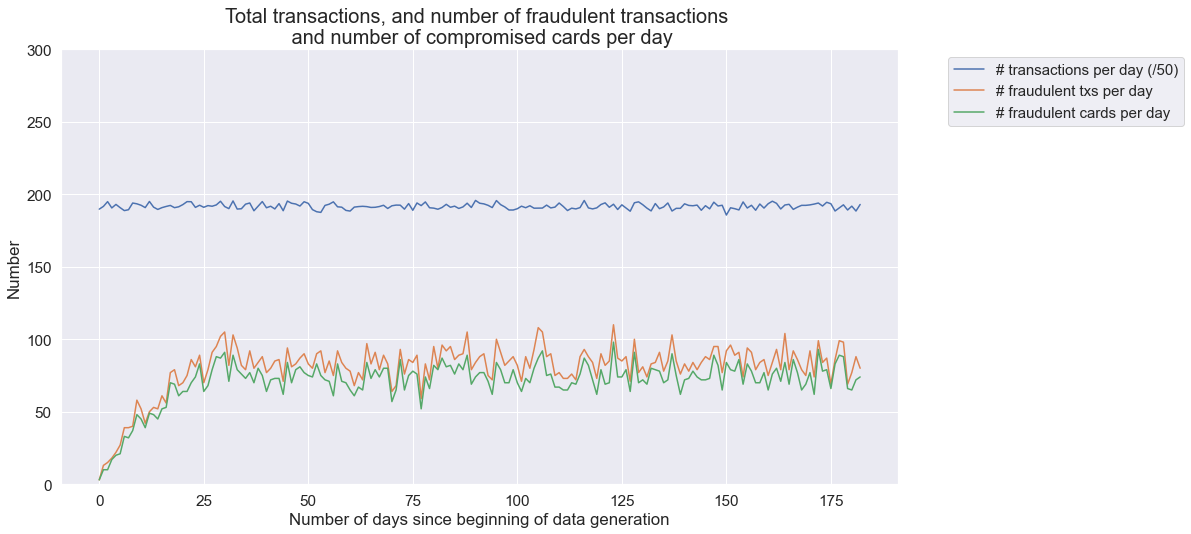

In [ ]:
fraud_and_transactions_stats_fig

This simulation generated around 10000 transactions per day. The number of fraudulent transactions per day is around 85, and the number of fraudulent cards around 80. It is worth noting that the first month has a lower number of fraudulent transactions, which is due to the fact that frauds from scenarios 2 and 3 span periods of 28 and 14 days, respectively. 

The resulting dataset is interesting: It features class imbalance (less than 1% of fraudulent transactions), a mix of numerical and categorical features, non-trivial relationships between features, and time-dependent fraud scenarios.

Let us finally save the dataset for reuse in the rest of this book.

##  Saving of dataset

Instead of saving the whole transaction dataset, we split the dataset into daily batches. This will allow later the loading of specific periods instead of the whole dataset. The pickle format is used, rather than CSV, to speed up the loading times. All files are saved in the `DIR_OUTPUT` folder. The names of the files are the dates, with the `.pkl` extension.

In [ ]:
DIR_OUTPUT = "./simulated-data-raw/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

The generated dataset is also available from Github at `https://github.com/Fraud-Detection-Handbook/simulated-data-raw`.